### Mounting, imports

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import re, string
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

dataset_path = '/content/drive/My Drive/NLP/dataset/'

### Shared Functions

In [0]:
# load and preprocess function
def load_data(dataset_path):
  pos = pd.read_csv(dataset_path + 'rt-polarity.pos', sep='\t', header=None, names=['Sentiment'])
  neg = pd.read_csv(dataset_path + 'rt-polarity.neg', sep='\t', header=None, names=['Sentiment'])
  pos['Target'] = 1
  neg['Target'] = 0

  X_full = pd.concat((pos, neg), axis=0, ignore_index=True)
  X_full = shuffle(X_full)

  X_train, X_test, y_train, y_test = train_test_split(X_full['Sentiment'].values, X_full['Target'].values, test_size=0.2)
  return X_full, X_train, X_test, y_train, y_test

# Printing out model accuracy, confusion matrix, plotting heatmap
def evaluate_model(y_true, predictions):
  cm = confusion_matrix(y_true, predictions)
  print("\nConfusion matrix: \n", cm)
  print("")
  cr = classification_report(y_true, predictions)
  print("Classification report: \n", cr)
  print("")
  sns.heatmap(cm, annot=True)
  plt.show()

# tokenize examples, filter symbols
def tokenize(s): 
  re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
  return re_tok.sub(r' \1 ', s).split()

# vectorize tokenized examples
def vectorizer(X_train, X_test):
  vect = TfidfVectorizer(use_idf=True)
#   strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True
  X_train_tfidf = vect.fit_transform(X_train)
  X_test_tfidf = vect.transform(X_test)
  return X_train_tfidf, X_test_tfidf

### Data

In [24]:
# loading training and testing datasets
X_full, X_train, X_test, y_train, y_test = load_data(dataset_path)

# for understanding with what king of data we're working
X_train[0]

'offers that rare combination of entertainment and education . '

### Vectorized data

In [0]:
# vectorizing training and testing datasets
tfidf_train, tfidf_test = vectorizer(X_train, X_test)

# Naive Bayes

## Functions

In [0]:
# Calculate Naive Bayes algorithm parameters
def calculations(X, y):
  p = X[y==1].sum(0) + 1
  q = X[y==0].sum(0) + 1
  r = np.log((p/p.sum())/(q/q.sum()))
  b = np.log(len(p) / len(q))
  return r, b

# Predict targets of given matrix using learned parameters
def predict_Bayes(X, r, b):
  pre_preds = X @ r.T + b
  predictions= pre_preds.T > 0
  return predictions

# Calculate our predictions accuracy
def accuracy(y_true, predictions):
  accuracy = (predictions == y_true).mean()*100
  return accuracy

## Model

In [27]:
bayes_time = time.time()
# calculating Naive Bayes model parameters
r, b = calculations(tfidf_train, y_train)

# predicting test data targets
predictions_bayes = predict_Bayes(tfidf_test, r, b)

# calculating our model accuracy
accuracy = accuracy(predictions_bayes, y_test)
print('Execution time: {}s'.format(time.time() - bayes_time))

Execution time: 0.004588127136230469s


## Results

Test accuracy: 77.87154242850445

Confusion matrix: 
 [[820 210]
 [262 841]]

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.80      0.78      1030
           1       0.80      0.76      0.78      1103

    accuracy                           0.78      2133
   macro avg       0.78      0.78      0.78      2133
weighted avg       0.78      0.78      0.78      2133




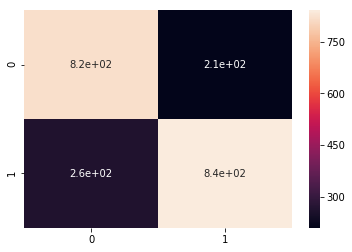

In [28]:
# printing accuracy
print('Test accuracy: {}'.format(accuracy))

# model evaluation (confusion matrix, heatmap)
evaluate_model(y_test, predictions_bayes.T)

# Logistic regression

## Functions

In [0]:
# Create logistic regression model and try 
# different hyperparameters for better performance
def create_model(C_range, penalties):
  grid={"C": C_range, "penalty": penalties}
  logreg = LogisticRegression()
  model = GridSearchCV(logreg, grid,cv=2)
  return model

## Model

In [30]:
# create a model with grid search for optimal hyperparameters
model = create_model(np.linspace(1,10,10), ["l1","l2"])

# train model
model.fit(tfidf_train, y_train)

# make predictions on test data
predictions_logistic = model.predict(tfidf_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Results

Best parameters are: {'C': 5.0, 'penalty': 'l2'}
Accuracy: 74.41669597842655 %

Confusion matrix: 
 [[784 246]
 [245 858]]

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      1030
           1       0.78      0.78      0.78      1103

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133




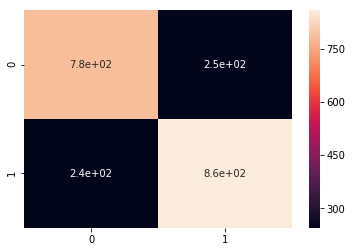

In [31]:
# best parameters
print('Best parameters are: {}'.format(model.best_params_))

# printing accuracy
print('Accuracy: {} %'.format(model.best_score_*100))

# model evaluation (confusion matrix, heatmap)
evaluate_model(y_test, predictions_logistic)

## Testing logistic regression execution time

In [32]:
start_log = time.time()
mod = LogisticRegression(C=5, penalty='l2')
mod.fit(tfidf_train, y_train)
acc = mod.score(tfidf_test, y_test)
print('Execution time: {}s'.format(time.time() - start_log))

Execution time: 0.08236956596374512s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
